In [1]:
import os
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumAtomStereoCenters
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rxn.chemutils.miscellaneous import is_valid_smiles

# Set the aesthetic style of the plots
sns.set_style("whitegrid")
sns.set_context(rc={"patch.linewidth": 0.0})

In [2]:
%%time
# Calculate descriptors for both datasets

choriso = pd.read_csv(
    "../data/processed/cjhif_atom_mapped_dataset.tsv", sep="\t"
)
uspto = pd.read_csv(
    "../data/processed/uspto_atom_mapped_dataset.tsv", sep="\t"
)


def calc_descrs(df):
    # Rdkit descriptors
    calculator = MolecularDescriptorCalculator(["MolWt"])
    df["products"] = df["canonic_rxn"].apply(lambda x: x.split(">>")[1])
    prods = df["products"][df["products"].apply(is_valid_smiles)].apply(
        Chem.MolFromSmiles
    )

    # Compute descriptors (for reaction product)
    df["MolWt"] = prods.apply(calculator.CalcDescriptors)

    # Calculate product stereocenters
    df["stereocenters"] = prods.apply(CalcNumAtomStereoCenters)

    return df


choriso = calc_descrs(choriso)
uspto = calc_descrs(uspto)

choriso["MolWt"] = choriso["MolWt"].apply(
    lambda x: x[0] if isinstance(x, tuple) else x
)
uspto["MolWt"] = uspto["MolWt"].apply(lambda x: x[0])

choriso.to_csv("../data/processed/choriso_props.tsv", sep="\t", index=False)
uspto.to_csv("../data/processed/uspto_props.tsv", sep="\t", index=False)

CPU times: user 18min 3s, sys: 12 s, total: 18min 15s
Wall time: 18min 15s


In [3]:
# Load precalculated dfs with properties

choriso = pd.read_csv("../data/processed/choriso_props.tsv", sep="\t")
uspto = pd.read_csv("../data/processed/uspto_props.tsv", sep="\t")

# Plot difference in distributions between ChORISO and USPTO

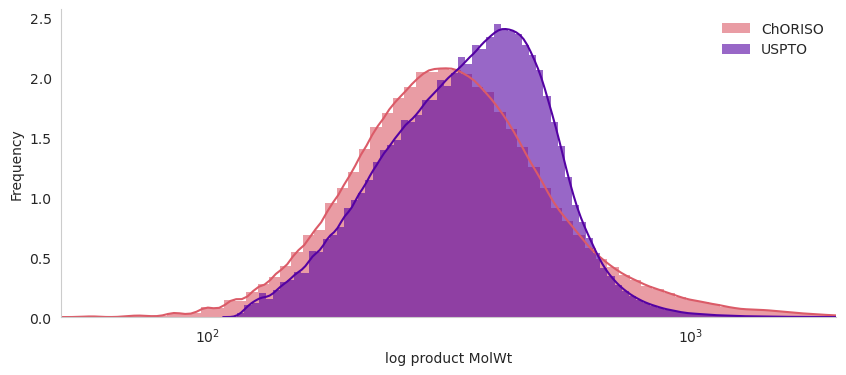

In [4]:
# Start the plot
plt.figure(figsize=(10, 4))

bins = 100
alpha = 0.6

# Plot the histograms and KDE for the ChORISO dataset
sns.histplot(
    choriso["MolWt"],
    color="#DB5B68",
    element="step",
    stat="density",
    bins=bins,
    kde=True,
    label="ChORISO",
    log_scale=True,
    alpha=alpha,
)

sns.histplot(
    uspto["MolWt"],
    color="#5402A3",
    element="step",
    stat="density",
    bins=bins,
    kde=True,
    label="USPTO",
    log_scale=True,
    alpha=alpha,
)

# Set the scale of x axis to log scale
# plt.xscale('log')

# Set the labels for x and y axis
plt.xlabel("log product MolWt")
plt.ylabel("Frequency")

# Set the x-axis ticks dynamically based on the data
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))

ax.get_yaxis().get_major_formatter().labelOnlyBase = True
ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f"$10^{{{int(np.log10(x))}}}$")
)

# Remove the top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlim(50, 2000)
ax.grid(False)

plt.legend()

# Plot distribution of stereocenters in products

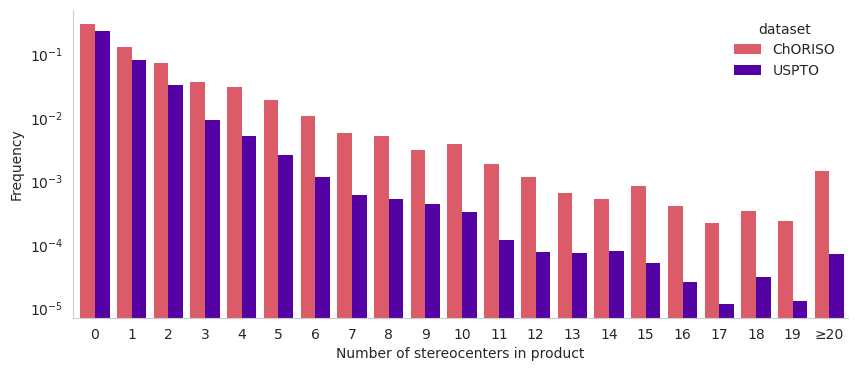

In [5]:
# Combine the data into one DataFrame for seaborn
combined_data = pd.concat(
    [
        choriso["stereocenters"]
        .clip(upper=20)
        .to_frame()
        .assign(dataset="ChORISO"),
        uspto["stereocenters"]
        .clip(upper=20)
        .to_frame()
        .assign(dataset="USPTO"),
    ]
).reset_index(drop=True)

# Start the plot
plt.figure(figsize=(10, 4))

# Define a common bin array for both histograms
bins = list(
    range(1, 22)
)  # This creates a list from 1 to 21 (since the last bin is inclusive)

# Plot the histogram for both datasets side by side
sns.histplot(
    data=combined_data[["stereocenters", "dataset"]],
    x="stereocenters",
    hue="dataset",
    palette=["#DB5B68", "#5402A3"],
    bins=bins,
    multiple="dodge",
    discrete=True,
    stat="density",
    shrink=0.8,
    alpha=1,
)

# Set the labels for x and y axis
plt.xlabel("Number of stereocenters in product")
plt.ylabel("Frequency")

# Remove the top and right spines
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set x-ticks and labels, using the Unicode character for 'greater than or equal to'
plt.xticks(
    ticks=[0] + bins[:-2] + [20],
    labels=[str(x) for x in range(0, 20)] + ["≥20"],
)

plt.yscale("log")

plt.xlim(-0.6, 20.5)
ax.grid(False)
# Show the plot
plt.show()

# Compare the distributions of reaction types, split by MolWt

/tmp/ipykernel_1777952/4195470594.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=20)


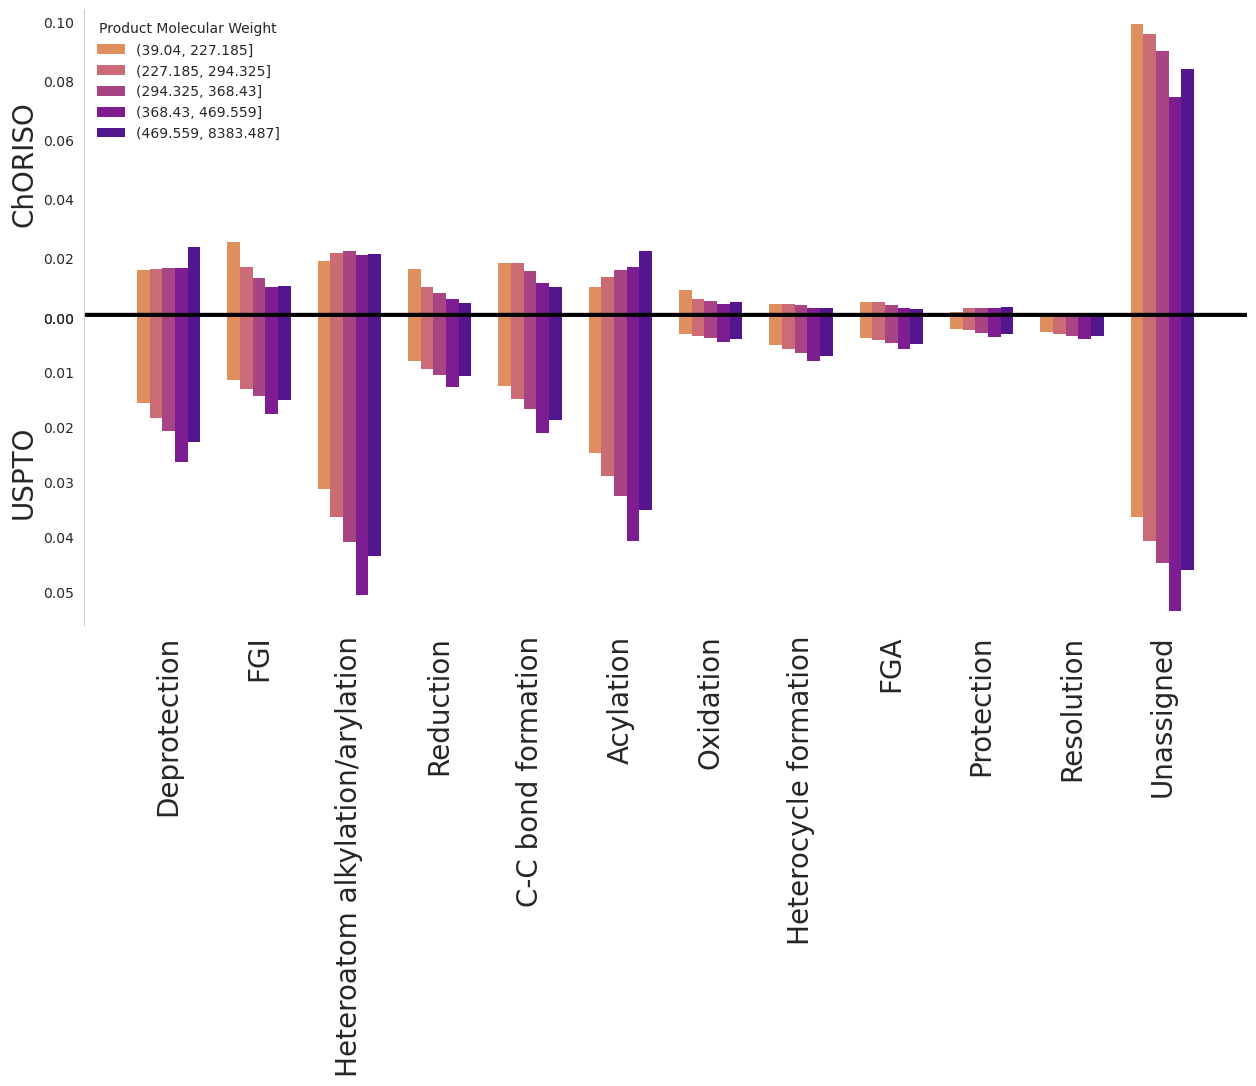

In [6]:
rxn_class_map = {
    "0": "Unassigned",
    "1": "Heteroatom alkylation/arylation",
    "2": "Acylation",
    "3": "C-C bond formation",
    "4": "Heterocycle formation",
    "5": "Protection",
    "6": "Deprotection",
    "7": "Reduction",
    "8": "Oxidation",
    "9": "FGI",
    "10": "FGA",
    "11": "Resolution",
    "12": "Miscelaneous",
}

x_ax_order = [
    "Deprotection",
    "FGI",
    "Heteroatom alkylation/arylation",
    "Reduction",
    "C-C bond formation",
    "Acylation",
    "Oxidation",
    "Heterocycle formation",
    "FGA",
    "Protection",
    "Resolution",
    "Unassigned",
]

# Get reation classes
choriso["cls_1"] = (
    choriso["rxn_class"]
    .fillna("0.0")
    .apply(lambda x: rxn_class_map[x.split(".")[0]])
)
uspto["cls_1"] = (
    uspto["rxn_class"]
    .fillna("0.0")
    .apply(lambda x: rxn_class_map[x.split(".")[0]])
)

# Convert into cats and use custom order
choriso["cls_1_cat"] = pd.Categorical(
    choriso["cls_1"], categories=x_ax_order, ordered=True
)
uspto["cls_1_cat"] = pd.Categorical(
    uspto["cls_1"], categories=x_ax_order, ordered=True
)

# Get MolWt bins
bins = pd.qcut(
    pd.concat([choriso["MolWt"], uspto["MolWt"]]), q=5
).cat.categories

# Cut both datasets
choriso["MWbins"] = pd.cut(choriso["MolWt"], bins=bins)
uspto["MWbins"] = pd.cut(uspto["MolWt"], bins=bins)

# Get counts for each combination of MolWt and rxn
cho_counts = choriso[["cls_1_cat", "MWbins"]].value_counts().reset_index()
usp_counts = uspto[["cls_1_cat", "MWbins"]].value_counts().reset_index()

cho_counts[0] /= cho_counts[0].sum()
usp_counts[0] /= -usp_counts[0].sum()


# Custom color palette
palette = ["#DF8E5E", "#CB6B75", "#A84484", "#7E1D92", "#54168F"]

fig, ax = plt.subplots(
    2, 1, figsize=(15, 8), sharex=True, gridspec_kw={"hspace": 0}
)

sns.histplot(
    data=choriso,
    x="cls_1_cat",
    hue="MWbins",
    palette=palette,
    alpha=1,
    shrink=0.7,
    multiple="dodge",
    stat="density",
    ax=ax[0],
)

sns.histplot(
    data=uspto,
    x="cls_1_cat",
    hue="MWbins",
    palette=palette,
    alpha=1,
    shrink=0.7,
    multiple="dodge",
    stat="density",
    ax=ax[1],
)

ax[1].invert_yaxis()
ax[0].axhline(0, color="k", linewidth=6)

plt.xticks(rotation=90)
legend = ax[0].get_legend()
legend.set_title("Product Molecular Weight")
ax[1].get_legend().remove()

ax[0].grid(False)
ax[1].grid(False)

# Remove the top and right spines
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[0].set_ylabel("ChORISO", fontsize=20)
ax[1].set_ylabel("USPTO", fontsize=20)

ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=20)
ax[1].set_xlabel("");